In [13]:
import os
from tqdm import tqdm
from typing import List, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Ручная разработка признаков может быть утомительным процессом, и часто полагается на опыт / знания о предметной области. Идея состоит в том, что затем модель будет определять, какие функции важны, а не нам решать это. По сути, наш подход состоит в том, чтобы создать как можно больше функций, а затем передать их модели для использования! Позже мы можем выполнить сокращение функций, используя значения функций из модели или другие методы, такие как PCA.

Процесс ручной разработки функций потребует большого количества кода Pandas, немного терпения и большого количества отличных практических манипуляций с данными. Несмотря на то, что инструменты автоматизированной разработки функций становятся доступными, разработка функций все равно должна выполняться с использованием большого количества данных в течение некоторого времени.

In [8]:
train = pd.read_csv("competition_data/train.csv")
train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [9]:
apps = pd.read_csv("competition_data/applications_history.csv")
apps.head(n=2)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0


In [10]:
train.shape[0], apps.shape[0]

(110093, 1670214)

__Пример:__ количество предыдущих заявок клиента.

Чтобы проиллюстрировать общий процесс ручного создания признаков, просто подсчитаем количество предыдущих заявок клиента в предыдущие месяцы. Для этого потребуется операции из `pandas`, которые мы будем интенсивно использовать:

* `groupby`: сгруппировать данные по клиенту, в этом случае мы будем группировать по уникальному ID клиента - `APPLICATION_NUMBER`

* `agg`: выполнить вычисление агрегаций данных, например, взяв среднее значение столбцов. Мы можем либо вызвать функцию напрямую `grouped_df.mean()`, либо использовать функцию `agg` вместе со списком преобразований `grouped_df.agg([mean, sum]))`;

* `merge`: слить агрегированную статистику с основным набором данных;

Мы также довольно часто используем функцию `rename`, указывая столбцы, которые нужно переименовать в словаре. Это полезно для отслеживания создаваемых нами новых признаков. Может показаться, что это много, поэтому в конечном итоге мы напишем функцию, которая будет выполнять этот процесс за нас. Давайте сначала посмотрим, как реализовать это вручную.

In [11]:
apps_groupby = apps.groupby("APPLICATION_NUMBER", as_index=False)
previous_app_counts = apps_groupby["PREV_APPLICATION_NUMBER"].count()
previous_app_counts = previous_app_counts.rename(columns={
    "PREV_APPLICATION_NUMBER": "PREV_APPS_COUNT"
})
previous_app_counts.head(n=3)

,APPLICATION_NUMBER,PREV_APPS_COUNT
0,123423340,1
1,123423341,1
2,123423342,3


In [12]:
train = train.merge(
    previous_app_counts, how="left", on="APPLICATION_NUMBER"
)
train["PREV_APPS_COUNT"] = train["PREV_APPS_COUNT"].fillna(0)
train.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPS_COUNT
0,123687442,0,Cash,3.0
1,123597908,1,Cash,4.0


## Оценка полезности новой переменной

Чтобы определить, полезна ли новая переменная, мы можем вычислить коэффициент корреляции Пирсона между этой переменной и целевой переменной. Он измеряет силу линейной связи между двумя переменными и находится в диапазоне от -1 (абсолютно отрицательно линейно) до +1 (абсолютно положительно линейно). Значение коэффициента корреляции не является лучшим показателем «полезности» новой переменной, но оно может дать первое приближение того, будет ли переменная полезной для модели машинного обучения. Чем больше значение переменной по отношению к целевой переменной, тем больше вероятность того, что изменение этой переменной повлияет на значение целевой переменной.

Мы также можем визуально проверить взаимосвязь с целевой переменной, используя график `Kernel Density Estimate (KDE)`.

График `Kernel Density Estimate (KDE)` показывает распределение одной переменной (можно интерпретировать этот график как сглаженную гистограмму); Например, построим такой график для оценки качества признака `PREV_APPS_COUNT`, распределенный по разным значениям целевой переменной. Полученный `KDE` покажет любые существенные различия в распределении переменной между клиентами, которые не выплатили свой кредит (`TARGET = 1`) и клиентов, которые выплатили кредит (`TARGET = 0`). Это может служить индикатором того, будет ли переменная "актуальной" для модели машинного обучения.

In [7]:
def plot_kde_target(feature_name: str, data: pd.DataFrame):
    """
    Визуализация функции распределения признаков в зависимости
    от значения целевой переменной на обучающей выборке.
    Вывод коэффициента корреляции между значением признака
    и значением целевой переменной, вывод медианы
    значений признака в разрезе целевой переменной.

    Parameters
    ----------
    faeture_name: str
        Название анализируемого признака.

    data: pandas.core.frame.DataFrame
        Матрица признаков для обучения.

    """
    corr = data["TARGET"].corr(data[feature_name])

    mask = data["TARGET"] == 1
    avg_target = data.loc[mask, feature_name].median()
    avg_non_target = data.loc[~mask, feature_name].median()

    fig = plt.figure(figsize=(12, 6))
    plt.title(f"{feature_name} Distribution", size=14)
    sns.kdeplot(data.loc[mask, feature_name], linewidth=3, color="blue", label="TARGET = 1")
    sns.kdeplot(data.loc[~mask, feature_name], linewidth=3, color="green", label="TARGET = 0")
    plt.legend(loc="best", fontsize=14)
    plt.xlabel(feature_name, size=14)
    plt.ylabel("Density", size=14)

    print(f"The correlation between {feature_name} and target = {round(corr, 4)}")
    print(f"Median-value for default-loan = {round(avg_target, 4)}")
    print(f"Median-value for non default-loan = {round(avg_target, 4)}")

The correlation between PREV_APPS_COUNT and target = 0.0008
Median-value for default-loan = 4.0
Median-value for non default-loan = 4.0


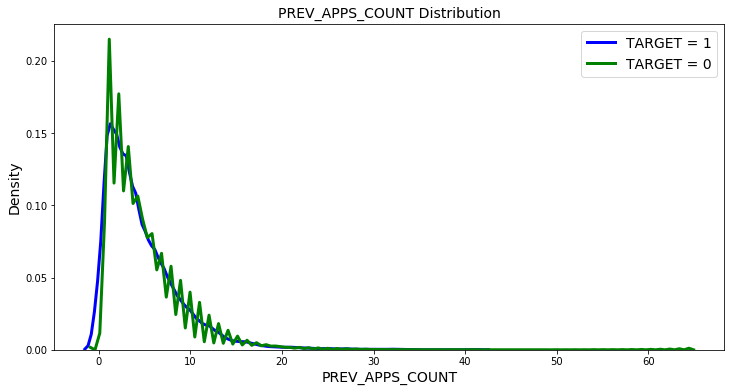

In [9]:
plot_kde_target("PREV_APPS_COUNT", train)

Из этого графика трудно сказать, будет ли эта переменная важна. Значение коэффициента корреляции крайне низкое и почти нет заметной разницы в распределениях. Давайте перейдем к созданию еще нескольких переменных. Мы возьмем среднее, минимальное и максимальное значение для числового столбца `AMT_APPLICATION`.

Визуальный способ анализа разделяющей способности переменных может быть не очень удобным. Тогда можно использовать __прокси-метрики__ для оценки силы связи между целевой переменной и признаком. Для задачи бинарной классификации, мы можем использовать метрику __ROC-AUC__ для оценки разделяющей способности признака: будем использовать целевую переменную в качестве истинных ответов, а значение признака в качестве предсказаний алгоритма. В связи с тем, что для метрики ROC-AUC важен порядок прогнозов, а не абсолютные значения, предложенный способ будет инвариантен относительно масштаба признаков, и мы сможем сравнивать разделяющую способность признаков между собой, не смотря на то, что они представлены в разных масштабах.

In [15]:
def calculate_feature_separating_ability(
    features: pd.DataFrame, target: pd.Series, fill_value: float = -9999) -> pd.DataFrame:
    """
    Оценка разделяющей способности признаков с помощью метрики GINI.

    Parameters
    ----------
    features: pandas.core.frame.DataFrame
        Матрица признаков.

    target: pandas.core.frame.Series
        Вектор целевой переменной.

    fill_value: float, optional, default = -9999
        Значение для заполнения пропусков в значении признаков.
        Опциональный параметр, по умолчанию, равен -9999;

    Returns
    -------
    scores: pandas.core.frame.DataFrame
        Матрица важности признаков.

    """
    scores = {}
    for feature in features:
        score = roc_auc_score(
            target, features[feature].fillna(fill_value)
        )
        scores[feature] = 2*score - 1

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [43]:
profile = pd.read_csv("./competition_data/client_profile.csv")

numerical = profile.select_dtypes(exclude=["object"])
numerical = numerical.merge(train["APPLICATION_NUMBER"], how="right", on="APPLICATION_NUMBER")

scores = calculate_feature_separating_ability(
    numerical, train["TARGET"]
)

## Aggregating Numeric Columns

Чтобы учесть сырые числовые признаки, мы можем вычислить статистику для всех числовых столбцов. Для этого мы группируем по идентификатору клиента, объединяем сгруппированные данные и объединяем полученную статистику с обучающей выборкой. Функция `agg` будет вычислять значения только для числовых столбцов, в которых операция считается допустимой. Мы будем использовать значения `mean`, `max`, `min`, `sum`, `std`, `skew`, `kurtosis`, но можно передать любую функцию. Мы даже можем написать нашу собственную функцию и использовать ее в вызове `agg`.

In [18]:
stats = ["count", "mean", "min", "max", "std"]
previous_app_numerical = apps_groupby["AMT_APPLICATION"].agg(stats).reset_index()
previous_app_numerical = previous_app_numerical.rename(
    columns={name: f"PREV_AMT_APPLICATION_{name.upper()}" for name in stats}
)
previous_app_numerical.head(n=3)

,APPLICATION_NUMBER,PREV_AMT_APPLICATION_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_STD
0,123423340,1,24835.5,24835.5,24835.5,NaN
1,123423341,1,179055.0,179055.0,179055.0,NaN
2,123423342,3,435436.5,68809.5,900000.0,424161.620549


In [19]:
previous_app_numerical_advanced_features = apps_groupby["AMT_APPLICATION"].agg([kurtosis, skew])
previous_app_numerical_advanced_features = previous_app_numerical_advanced_features.reset_index()
previous_app_numerical_advanced_features = previous_app_numerical_advanced_features.rename(
    columns={name: f"PREV_AMT_APPLICATION_{name.upper()}" for name in ["kurtosis", "skew"]}
)
previous_app_numerical_advanced_features.head(n=3)

,APPLICATION_NUMBER,PREV_AMT_APPLICATION_KURTOSIS,PREV_AMT_APPLICATION_SKEW
0,123423340,-3.0,0.000000
1,123423341,-3.0,0.000000
2,123423342,-1.5,0.401566


In [20]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [21]:
aggs = {
    "AMT_APPLICATION": [np.mean, np.std, np.sum, "max"],
    "CNT_PAYMENT": [np.mean]
}

stats = create_numerical_aggs(
    apps, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="PREV_APP_"
)
stats.head(n=2)

,APPLICATION_NUMBER,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_STD,PREV_APP_AMT_APPLICATION_SUM,PREV_APP_AMT_APPLICATION_MAX,PREV_APP_CNT_PAYMENT_MEAN
0,123423340,24835.5,NaN,24835.5,24835.5,8.0
1,123423341,179055.0,NaN,179055.0,179055.0,24.0


## Aggregating Categorical Columns

Для категориальных признаков, мы можем написать похожую функцию, которая будет принимать сырые данные и выполнять количество и среднее значение наблюдений для каждого значения категории по категориальным признакам.

In [22]:
def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    """
    Построение агрегаций для категориальных признаков.
    Для категориальных признако считаются счетчики для
    каждого значения категории и среднее значение счетчика
    для каждого значения категории.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    features: List[str]
        Список с названием признаков, для которых произвести
        группировку.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

In [23]:
stats = create_categorical_aggs(
    apps, groupby_id="APPLICATION_NUMBER", features=["NAME_CONTRACT_STATUS"], prefix=""
)
stats.head(n=2)

,APPLICATION_NUMBER,NAME_CONTRACT_STATUS_APPROVED_RATIO,NAME_CONTRACT_STATUS_APPROVED_TOTAL,NAME_CONTRACT_STATUS_CANCELED_RATIO,NAME_CONTRACT_STATUS_CANCELED_TOTAL,NAME_CONTRACT_STATUS_REFUSED_RATIO,NAME_CONTRACT_STATUS_REFUSED_TOTAL,NAME_CONTRACT_STATUS_UNUSED OFFER_RATIO,NAME_CONTRACT_STATUS_UNUSED OFFER_TOTAL
0,123423340,1.0,1,0.0,0,0.0,0,0.0,0
1,123423341,1.0,1,0.0,0,0.0,0,0.0,0


## GroupBy and Delta

Помимо группировки по сырым данным, которые не имеют структуру, мы можем проводить группировки по уже структурированным данным, например используя категориальные переменные. После чего мы можем считать отклонение или отношение рассчитанной статистики в каждой группе к значению статистики по всему набору данных.

In [24]:
profile.head(n=2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [25]:
aggs = {
    "TOTAL_SALARY": ["mean"],
    "AMOUNT_CREDIT": ["mean"],
}

stats = create_numerical_aggs(
    profile, groupby_id="EDUCATION_LEVEL", aggs=aggs, suffix="_BY_EDUCATION"
)
stats

,EDUCATION_LEVEL,TOTAL_SALARY_MEAN_BY_EDUCATION,AMOUNT_CREDIT_MEAN_BY_EDUCATION
0,Academic degree,244621.323529,729561.606618
1,Higher education,208989.672806,689809.957142
2,Incomplete higher,181446.844502,565921.004786
3,Lower secondary,130223.217137,491498.704966
4,Secondary / secondary special,155414.744584,571624.325064


In [26]:
profile_stats = profile[["APPLICATION_NUMBER", "EDUCATION_LEVEL", "TOTAL_SALARY", "AMOUNT_CREDIT"]]
profile_stats = profile_stats.merge(
    stats, how="left", on="EDUCATION_LEVEL"
)
profile_stats["TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = profile_stats["TOTAL_SALARY"] / profile_stats["TOTAL_SALARY_MEAN_BY_EDUCATION"]
profile_stats["DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = profile_stats["TOTAL_SALARY"] - profile_stats["TOTAL_SALARY_MEAN_BY_EDUCATION"]
profile_stats.head(n=3)

,APPLICATION_NUMBER,EDUCATION_LEVEL,TOTAL_SALARY,AMOUNT_CREDIT,TOTAL_SALARY_MEAN_BY_EDUCATION,AMOUNT_CREDIT_MEAN_BY_EDUCATION,TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION,DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION
0,123666076,Incomplete higher,157500.0,270000.0,181446.844502,565921.004786,0.868023,-23946.844502
1,123423688,Secondary / secondary special,270000.0,536917.5,155414.744584,571624.325064,1.737287,114585.255416
2,123501780,Incomplete higher,427500.0,239850.0,181446.844502,565921.004786,2.356062,246053.155498


## Ratios

Кроме того, признаки можно создавать на основе экспертных / предметных знаний о предметной области. Можно использовать отношение одной величины к другой, разницу между двумя величинами, сумму двух признаков и т.д.

In [27]:
# финансовые признаки
profile["RATIO_SALARY_TO_AMOUNT_CREDIT"] = profile["TOTAL_SALARY"] / profile["AMOUNT_CREDIT"]
profile["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = profile["AMOUNT_ANNUITY"] / profile["TOTAL_SALARY"]

# семейные признаки
profile["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = profile["TOTAL_SALARY"] / profile["FAMILY_SIZE"]

# флаги
profile["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(
    profile["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.3, 1, 0
)

## Features Interaction

Рассмотрим два категориальных признака, например это __уровень образования__ и __семейное положение__. Конечно, мы можме использовать эти признаки как два независимых признака, но __очень важным__ является их сочетание. Мы можем построить комбинацию этих признаков, и включить дополнительные знания в модель. Давайте добавим такой признак, он будет категориальным, как и исходные признаки, но набор его значений будет представлять собой все возможные комбинации двух исходных признаков. Первый подход заключается в том, что мы __конкатенируем строки__ и получаем новый категориальный признак, который представлен строкой, после чего используем методы работы с категориальными данными для обработки нового признака.

In [28]:
categorical = profile[["EDUCATION_LEVEL", "FAMILY_STATUS"]]
categorical.head(n=2)

,EDUCATION_LEVEL,FAMILY_STATUS
0,Incomplete higher,Civil marriage
1,Secondary / secondary special,Married


In [29]:
categorical["EDUCATION_FAMILY_STATUS"] = categorical["EDUCATION_LEVEL"] + " | " + categorical["FAMILY_STATUS"]
categorical.head(n=2)

/Users/nv27/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,EDUCATION_LEVEL,FAMILY_STATUS,EDUCATION_FAMILY_STATUS
0,Incomplete higher,Civil marriage,Incomplete higher | Civil marriage
1,Secondary / secondary special,Married,Secondary / secondary special | Married


Другой подход к построению взаимодействий заключается в обратной идеи. __Например__, сначала мы можем применить `OneHotEncoding` для независимого преобразования категориальных признаков, а затем создадим новые признаки, обрабатывая полученные данные.

In [30]:
gender_dummies = pd.get_dummies(profile["GENDER"])
family_status_dummies = pd.get_dummies(profile["FAMILY_STATUS"])

categorical = pd.concat([gender_dummies, family_status_dummies], axis=1)
categorical.head(n=2)

,F,M,XNA,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0


## Отбор признаков

In [31]:
train = train.merge(
    profile, how="left", on="APPLICATION_NUMBER"
)
train = train.select_dtypes(exclude=["object"])
train.head(n=2)

,APPLICATION_NUMBER,TARGET,PREV_APPS_COUNT,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT
0,123687442,0,3.0,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.184211,0.159543,52500.0,0.0
1,123597908,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
x_train, x_valid = train_test_split(
    train.drop(["TARGET", "APPLICATION_NUMBER"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    train["TARGET"], train_size=0.7, random_state=1
)

In [33]:
model = RandomForestClassifier(max_depth=8, random_state=27, n_jobs=2)
model.fit(x_train.fillna(-9999), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

## Пермутированная важность (permutation importance)

Способ вычисления важности признаков на основе усредненного уменьшения качества модели.

__Алгоритм вычисления:__

* выбираем метрику для вычислений;
* фиксируем значение метрики на валидационном наборе данных (базовое качество модели);
* для каждого признака делаем:
 * переставляем значения одного признака и применяем модель;
 * оцениваем качество модели с помощью заданной метрики;
 * важность признака оценивается разницей между базовым качество модели (качество на исходном наборе данных) и качеством после пермутации признака; 
 
__Плюсы:__
* гораздо более надежный подход к оценке важности признаков;
* не трубует повторного обучения моделей;
* работает для любой класса моделей машинного обучения;

__Минусы:__
* не позволяет оценить вклад признака в прогнозное значение модели;
* вычислительно сложнее встроенных методов оценки важности признаков;
* потенциальное смещение в пользу коррелирующих между собой признаков.

In [39]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict_proba(x_valid)[:, 1]
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict_proba(x_valid_copy)[:, 1]
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [40]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=x_valid.fillna(-9999), y_valid=y_valid
)

100%|██████████| 25/25 [00:05<00:00,  4.27it/s]


In [41]:
perm_importance

EXTERNAL_SCORING_RATING_2             0.080096
EXTERNAL_SCORING_RATING_3             0.072621
RATIO_SALARY_TO_AMOUNT_CREDIT         0.048111
AGE                                   0.035155
DAYS_ON_LAST_JOB                      0.027585
RATIO_AMOUNT_ANNUITY_TO_SALARY        0.026020
REGION_POPULATION                     0.017388
EXTERNAL_SCORING_RATING_1             0.016976
AMOUNT_CREDIT                         0.015335
RATIO_SALARY_TO_PER_FAMILY_SIZE       0.015008
AMOUNT_ANNUITY                        0.012046
TOTAL_SALARY                          0.002659
PREV_APPS_COUNT                       0.000663
FAMILY_SIZE                           0.000360
FLG_MORE_THAN_30PERCENT_FOR_CREDIT    0.000341
AMT_REQ_CREDIT_BUREAU_YEAR            0.000260
AMT_REQ_CREDIT_BUREAU_WEEK            0.000216
AMT_REQ_CREDIT_BUREAU_HOUR            0.000146
FLAG_PHONE                            0.000020
FLAG_EMAIL                           -0.000062
CHILDRENS                            -0.000099
AMT_REQ_CREDI